In [1]:
import pandas as pd
import geopandas as gpd #geopandas for dataframes with spatial info
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt #for creating plots
%matplotlib inline
import os #operating system, to create folders
import seaborn as sns #for styling the plots
import statsmodels.formula.api as smf
import warnings
import urllib.request
warnings.filterwarnings('ignore')
import sys
import mapclassify

In [2]:
race = pd.read_csv('Data_original/TotalPopulationbyRace_Ethnicity.csv',  error_bad_lines=False, skiprows=4)
race

,Location,Race/Ethnicity,TimeFrame,DataFormat,Data,Fips
0,Riverdale,Asian,2009,Number,5647.00000,208
1,Williamsbridge,Asian,2009,Number,3194.00000,212
2,Throgs Neck,Asian,2009,Number,2613.00000,210
3,Pelham Parkway,Asian,2009,Number,9459.00000,211
4,Morrisania,Asian,2009,Number,667.33342,203
...,...,...,...,...,...,...
6495,Brooklyn,White,2018,Percent,0.36173,36047
6496,Manhattan,White,2018,Percent,0.46896,36061
6497,Queens,White,2018,Percent,0.25293,36081
6498,Staten Island,White,2018,Percent,0.61666,36085


In [3]:
race.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Location        6500 non-null   object 
 1   Race/Ethnicity  6500 non-null   object 
 2   TimeFrame       6500 non-null   int64  
 3   DataFormat      6500 non-null   object 
 4   Data            6500 non-null   float64
 5   Fips            6500 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 304.8+ KB


In [4]:
race.describe()

,TimeFrame,Data,Fips
count,6500.000000,6.500000e+03,6.500000e+03
mean,2013.500000,3.841200e+04,5.919718e+04
std,2.872502,1.857538e+05,4.491110e+05
min,2009.000000,4.780000e-03,1.010000e+02
25%,2011.000000,1.192875e-01,2.050000e+02
50%,2013.500000,1.881789e+02,3.090000e+02
75%,2016.000000,1.836825e+04,4.070000e+02
max,2018.000000,2.945058e+06,3.651000e+06


In [8]:
# work with total values

In [5]:
drop_locations = ['New York City', 'Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
drop_years = (race.TimeFrame > 2012) & (race.TimeFrame < 2018)
drop_percent = (race['DataFormat'] == 'Number')

race_nr = race[~race['Location'].isin(drop_locations)]
race_nr = race_nr[drop_years]
race_nr = race_nr[drop_percent]
race_nr = race_nr.rename(columns={'Race/Ethnicity':'Race', 'TimeFrame':'Year', 'Data':'Total', 'Fips':'LocationId'})
race_nr = race_nr.sort_values('LocationId')
race_nr = race_nr.drop(['DataFormat'], axis=1)
race_nr = race_nr.reset_index(drop=True)
race_nr

,Location,Race,Year,Total,LocationId
0,Battery Park/Tribeca,Latino,2015,4231.87982,101
1,Battery Park/Tribeca,Latino,2016,4374.03286,101
2,Battery Park/Tribeca,White,2015,44366.28661,101
3,Battery Park/Tribeca,Latino,2017,4086.49603,101
4,Battery Park/Tribeca,Black,2014,1424.35730,101
...,...,...,...,...,...
1470,Tottenville,Asian,2014,7253.00000,503
1471,Tottenville,Black,2014,1833.00000,503
1472,Tottenville,White,2015,139172.00000,503
1473,Tottenville,Black,2015,1613.00000,503


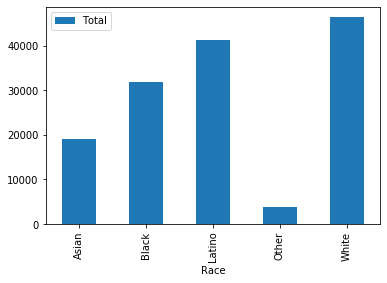

In [6]:
race_nr[['Total','Race']].groupby(by='Race').mean().plot.bar()

In [7]:
output_nr = race_nr.pivot_table("Total",['LocationId','Year'],"Race")
output_nr.reset_index(drop=False, inplace=True)
output_nr.rename_axis(None, axis=1, inplace=True)
output_nr = output_nr[['LocationId', 'Year', 'White', 'Latino', 'Black', 'Asian', 'Other']]

In [8]:
output_nr

,LocationId,Year,White,Latino,Black,Asian,Other
0,101,2013,43279.13893,4110.72666,1343.58853,9416.42731,2026.89234
1,101,2014,44389.70955,4230.26445,1424.35730,9248.02442,2127.44946
2,101,2015,44366.28661,4231.87982,1400.93436,9736.67550,2160.16081
3,101,2016,44968.82165,4374.03286,1398.10745,9987.46253,2064.44982
4,101,2017,45882.31646,4086.49603,1467.16475,10005.23166,2249.81415
...,...,...,...,...,...,...,...
290,503,2013,137888.00000,16071.00000,1672.00000,6691.00000,1183.00000
291,503,2014,138658.00000,16755.00000,1833.00000,7253.00000,1464.00000
292,503,2015,139172.00000,16656.00000,1613.00000,7678.00000,1472.00000
293,503,2016,138438.00000,16089.00000,1419.00000,7733.00000,1953.00000


In [9]:
yearly = output_nr[['White', 'Latino', 'Black', 'Asian', 'Other', 'Year']].groupby(by='Year').sum()
yearly

,White,Latino,Black,Asian,Other
Year,,,,,
2013,2734318.0,2371116.0,1877183.0,1073172.0,213210.0
2014,2735098.0,2407983.0,1886662.0,1101324.0,223838.0
2015,2739755.0,2437297.0,1885102.0,1133195.0,231411.0
2016,2729973.0,2457945.0,1879383.0,1153515.0,241173.0
2017,2747159.0,2491496.0,1885909.0,1191243.0,244313.0


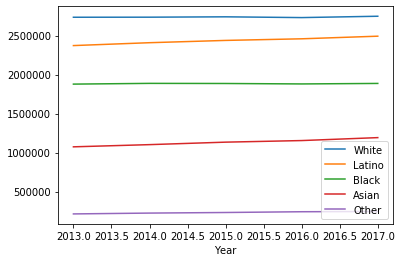

In [10]:
yearly.plot()

In [15]:
# work with percentages

In [11]:
drop_locations = ['New York City', 'Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
drop_years = (race.TimeFrame > 2012) & (race.TimeFrame < 2018)
drop_number = (race['DataFormat'] == 'Percent')

race_percent = race[~race['Location'].isin(drop_locations)]
race_percent = race_percent[drop_years]
race_percent = race_percent[drop_number]
race_percent = race_percent.rename(columns={'Race/Ethnicity':'Race', 'TimeFrame':'Year', 'Data':'Total', 'Fips':'LocationId'})
race_percent = race_percent.sort_values('LocationId')
race_percent = race_percent.drop(['DataFormat'], axis=1)
race_percent = race_percent.reset_index(drop=True)
race_percent

,Location,Race,Year,Total,LocationId
0,Battery Park/Tribeca,Other,2013,0.03368,101
1,Battery Park/Tribeca,Black,2017,0.02304,101
2,Battery Park/Tribeca,Latino,2014,0.06887,101
3,Battery Park/Tribeca,Black,2013,0.02233,101
4,Battery Park/Tribeca,White,2015,0.71679,101
...,...,...,...,...,...
1470,Tottenville,White,2013,0.84333,503
1471,Tottenville,Other,2017,0.00944,503
1472,Tottenville,Latino,2014,0.10096,503
1473,Tottenville,Latino,2016,0.09714,503


In [12]:
output_percent = race_percent.pivot_table("Total",['LocationId','Year'],"Race")
output_percent.reset_index(drop=False, inplace=True)
output_percent.rename_axis(None, axis=1, inplace=True)
output_percent = output_percent[['LocationId', 'Year', 'White', 'Latino', 'Black', 'Asian', 'Other']]
output_percent.rename(columns={'White':'%White', 'Latino':'%Latino', 'Black':'%Black', 'Asian':'%Asian', 'Other':'%Other'}, inplace=True)
output_percent

,LocationId,Year,%White,%Latino,%Black,%Asian,%Other
0,101,2013,0.71920,0.06831,0.02233,0.15648,0.03368
1,101,2014,0.72273,0.06887,0.02319,0.15057,0.03464
2,101,2015,0.71679,0.06837,0.02263,0.15731,0.03490
3,101,2016,0.71615,0.06966,0.02227,0.15905,0.03288
4,101,2017,0.72039,0.06416,0.02304,0.15709,0.03532
...,...,...,...,...,...,...,...
290,503,2013,0.84333,0.09829,0.01023,0.04092,0.00724
291,503,2014,0.83548,0.10096,0.01104,0.04370,0.00882
292,503,2015,0.83541,0.09998,0.00968,0.04609,0.00884
293,503,2016,0.83582,0.09714,0.00857,0.04669,0.01179


In [13]:
# merge total values and percentages

In [14]:
output = output_nr.merge(output_percent,on=['LocationId', 'Year'],how='left')
output

,LocationId,Year,White,Latino,Black,Asian,Other,%White,%Latino,%Black,%Asian,%Other
0,101,2013,43279.13893,4110.72666,1343.58853,9416.42731,2026.89234,0.71920,0.06831,0.02233,0.15648,0.03368
1,101,2014,44389.70955,4230.26445,1424.35730,9248.02442,2127.44946,0.72273,0.06887,0.02319,0.15057,0.03464
2,101,2015,44366.28661,4231.87982,1400.93436,9736.67550,2160.16081,0.71679,0.06837,0.02263,0.15731,0.03490
3,101,2016,44968.82165,4374.03286,1398.10745,9987.46253,2064.44982,0.71615,0.06966,0.02227,0.15905,0.03288
4,101,2017,45882.31646,4086.49603,1467.16475,10005.23166,2249.81415,0.72039,0.06416,0.02304,0.15709,0.03532
...,...,...,...,...,...,...,...,...,...,...,...,...
290,503,2013,137888.00000,16071.00000,1672.00000,6691.00000,1183.00000,0.84333,0.09829,0.01023,0.04092,0.00724
291,503,2014,138658.00000,16755.00000,1833.00000,7253.00000,1464.00000,0.83548,0.10096,0.01104,0.04370,0.00882
292,503,2015,139172.00000,16656.00000,1613.00000,7678.00000,1472.00000,0.83541,0.09998,0.00968,0.04609,0.00884
293,503,2016,138438.00000,16089.00000,1419.00000,7733.00000,1953.00000,0.83582,0.09714,0.00857,0.04669,0.01179


In [15]:
# calculate max race per locationId

cols_race = ['White', 'Latino', 'Black', 'Asian', 'Other']
output['max_race'] = np.where(output[cols_race].eq(output[cols_race].max(axis=1), axis=0).sum(axis=1)>1,
                                 'No Max', output[cols_race].idxmax(axis=1))
output

,LocationId,Year,White,Latino,Black,Asian,Other,%White,%Latino,%Black,%Asian,%Other,max_race
0,101,2013,43279.13893,4110.72666,1343.58853,9416.42731,2026.89234,0.71920,0.06831,0.02233,0.15648,0.03368,White
1,101,2014,44389.70955,4230.26445,1424.35730,9248.02442,2127.44946,0.72273,0.06887,0.02319,0.15057,0.03464,White
2,101,2015,44366.28661,4231.87982,1400.93436,9736.67550,2160.16081,0.71679,0.06837,0.02263,0.15731,0.03490,White
3,101,2016,44968.82165,4374.03286,1398.10745,9987.46253,2064.44982,0.71615,0.06966,0.02227,0.15905,0.03288,White
4,101,2017,45882.31646,4086.49603,1467.16475,10005.23166,2249.81415,0.72039,0.06416,0.02304,0.15709,0.03532,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,503,2013,137888.00000,16071.00000,1672.00000,6691.00000,1183.00000,0.84333,0.09829,0.01023,0.04092,0.00724,White
291,503,2014,138658.00000,16755.00000,1833.00000,7253.00000,1464.00000,0.83548,0.10096,0.01104,0.04370,0.00882,White
292,503,2015,139172.00000,16656.00000,1613.00000,7678.00000,1472.00000,0.83541,0.09998,0.00968,0.04609,0.00884,White
293,503,2016,138438.00000,16089.00000,1419.00000,7733.00000,1953.00000,0.83582,0.09714,0.00857,0.04669,0.01179,White


In [21]:
# save as csv
#output.to_csv('Race_geo_clean.csv', index=False)

In [17]:
# community district geojson

cd = gpd.read_file('https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Community_Districts/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson')
raceGeo = cd.merge(output,left_on='BoroCD',right_on='LocationId',how='left')
raceGeo

,OBJECTID,BoroCD,Shape__Area,Shape__Length,geometry,LocationId,Year,White,Latino,Black,Asian,Other,%White,%Latino,%Black,%Asian,%Other,max_race
0,1,101,4.268909e+07,74168.382652,"MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ...",101.0,2013.0,43279.13893,4110.72666,1343.58853,9416.42731,2026.89234,0.71920,0.06831,0.02233,0.15648,0.03368,White
1,1,101,4.268909e+07,74168.382652,"MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ...",101.0,2014.0,44389.70955,4230.26445,1424.35730,9248.02442,2127.44946,0.72273,0.06887,0.02319,0.15057,0.03464,White
2,1,101,4.268909e+07,74168.382652,"MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ...",101.0,2015.0,44366.28661,4231.87982,1400.93436,9736.67550,2160.16081,0.71679,0.06837,0.02263,0.15731,0.03490,White
3,1,101,4.268909e+07,74168.382652,"MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ...",101.0,2016.0,44968.82165,4374.03286,1398.10745,9987.46253,2064.44982,0.71615,0.06966,0.02227,0.15905,0.03288,White
4,1,101,4.268909e+07,74168.382652,"MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ...",101.0,2017.0,45882.31646,4086.49603,1467.16475,10005.23166,2249.81415,0.72039,0.06416,0.02304,0.15709,0.03532,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,70,503,5.990542e+08,188997.534820,"MULTIPOLYGON (((-74.13320 40.53631, -74.13301 ...",503.0,2014.0,138658.00000,16755.00000,1833.00000,7253.00000,1464.00000,0.83548,0.10096,0.01104,0.04370,0.00882,White
303,70,503,5.990542e+08,188997.534820,"MULTIPOLYGON (((-74.13320 40.53631, -74.13301 ...",503.0,2015.0,139172.00000,16656.00000,1613.00000,7678.00000,1472.00000,0.83541,0.09998,0.00968,0.04609,0.00884,White
304,70,503,5.990542e+08,188997.534820,"MULTIPOLYGON (((-74.13320 40.53631, -74.13301 ...",503.0,2016.0,138438.00000,16089.00000,1419.00000,7733.00000,1953.00000,0.83582,0.09714,0.00857,0.04669,0.01179,White
305,70,503,5.990542e+08,188997.534820,"MULTIPOLYGON (((-74.13320 40.53631, -74.13301 ...",503.0,2017.0,138120.00000,16438.00000,1725.00000,7751.00000,1564.00000,0.83407,0.09926,0.01042,0.04681,0.00944,White


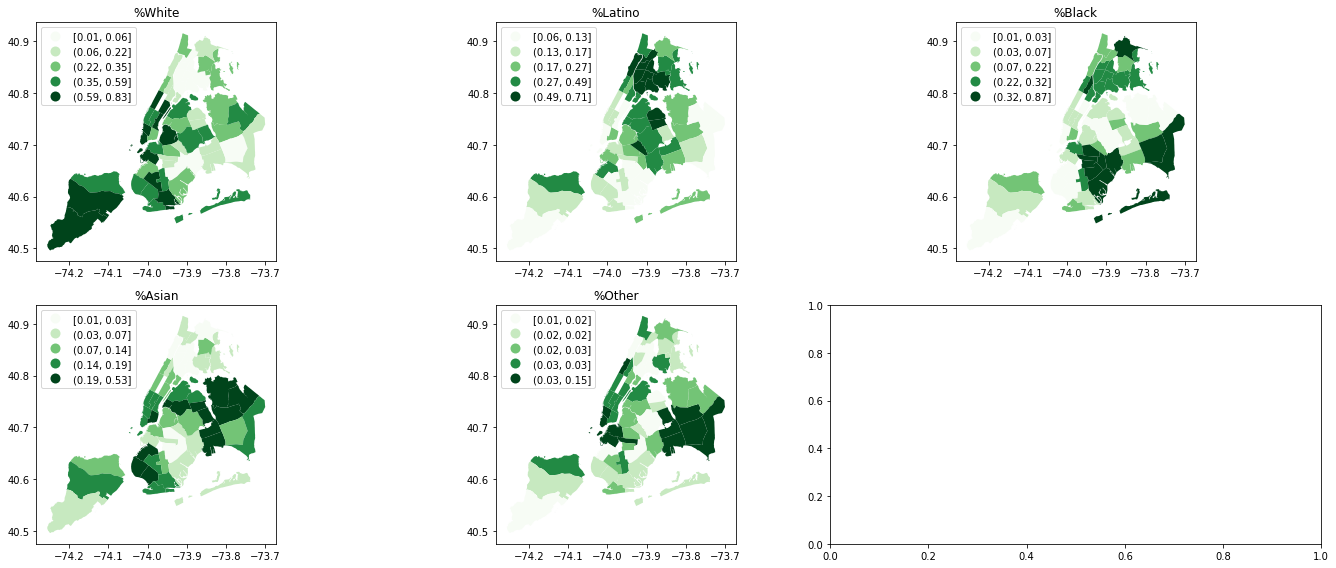

In [19]:
# percentage race per cd

fig, ax = plt.subplots(2,3, figsize=(20,8))

color_race = 'Greens'

raceGeo[raceGeo.Year == 2017].plot(ax=ax[0][0], column='%White', k=5, scheme='Quantiles', colormap=color_race,legend=True, 
              legend_kwds={'loc': 'upper left'})
raceGeo[raceGeo.Year == 2017].plot(ax=ax[0][1], column='%Latino', k=5, scheme='Quantiles', colormap=color_race,legend=True, 
              legend_kwds={'loc': 'upper left'})
raceGeo[raceGeo.Year == 2017].plot(ax=ax[0][2], column='%Black', k=5, scheme='Quantiles', colormap=color_race,legend=True, 
              legend_kwds={'loc': 'upper left'})
raceGeo[raceGeo.Year == 2017].plot(ax=ax[1][0], column='%Asian', k=5, scheme='Quantiles', colormap=color_race,legend=True, 
              legend_kwds={'loc': 'upper left'})
raceGeo[raceGeo.Year == 2017].plot(ax=ax[1][1], column='%Other', k=5, scheme='Quantiles', colormap=color_race,legend=True, 
              legend_kwds={'loc': 'upper left'})

ax[0][0].set_title('%White')
ax[0][1].set_title('%Latino')
ax[0][2].set_title('%Black')
ax[1][0].set_title('%Asian')
ax[1][1].set_title('%Other')
fig.tight_layout()

plt.show()

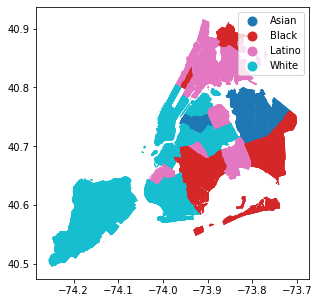

In [20]:
# max race per cd

fig, ax = plt.subplots(1, figsize=(15,5))
raceGeo.plot(ax=ax, column='max_race',legend=True)
#ax.legend(raceGeo.max_race.legend_elements(), bbox_to_anchor=(1,1), loc='upper left', title='Max Race')

plt.show()